In [0]:
import networkx as nx
from matplotlib import rc
import matplotlib.pyplot as plt

rc('font',**{'family':'serif','serif':['Computer Modern'],'size': 21})
rc('text', usetex=True)
import random as rn

In [0]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.topics = ['religion', 'politics', 'socioeconomic status']

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(100, 5, 0.5)

        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5            
        for node in self.graph.nodes:
            for topic in self.topics:
                self.graph.nodes[node][topic] = rn.randint(0, 1)
            
        self.layout = nx.spring_layout(self.graph)
        self.step = 0
        
    def initialize_fb(self):
        self.graph = nx.read_edgelist('facebook_combined.txt', 
                                      create_using=nx.Graph(), nodetype=int)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = rn.randint(0, 1)
        #self.layout = nx.spring_layout(self.graph)
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph,pos=self.layout,iterations=5)
        plt.figure(figsize=(20, 7))
        for k in range(len(self.topics)):
            plt.subplot(1, 3, k+1)
            nx.draw(
            self.graph, pos=self.layout, with_labels=True, edgecolors='black',
            node_color=[self.graph.nodes[i][self.topics[k]] for i in self.graph.nodes],
            cmap='seismic', alpha=0.7, vmin=0, vmax=1, node_size=450,
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
            plt.title('Graph of '+self.topics[k]+' - step: ' + str(self.step), fontsize=16)
        plt.show()
      
    def update(self):
        # Part I: creating a new edge with probability of 1%
        if rn.uniform(0,1) < 0.01:
            # Create a new edge between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = rn.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            
            # ORIGINAL
            #self.graph.add_edge(new_edge[0], new_edge[1], weight=.5)
            
            # MODIFICATION
            # The weight of the new edge is proportional to the degree of separation
            if nx.has_path(self.graph, new_edge[0], new_edge[1]):
                new_weight = 1 / (nx.shortest_path_length(self.graph, new_edge[0], new_edge[1]))
            else: 
                # Connected_Component_Subgraphs: Sort all subgraphs based on length
                CCS = sorted(nx.connected_components(self.graph), key=len, reverse=True)
                # Identify the giant component of the graph
                GC = self.graph.subgraph(CCS[0])
                # Attribute the appropriate wieght to the new edge
                new_weight = 1 / (nx.diameter(GC) + 1)
                
            # Assign the weight to the newly-formed connection
            self.graph.add_edge(new_edge[0], new_edge[1], weight=new_weight)
            
        # Part II: update the edge weight and opinions of a random couple
        else:
            # Select a random edge and update node opinions and edge weight
            edge = rn.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            # ORIGINAL
            #opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            # MODIFICATION
            topic = rn.choice(self.topics)
            opinions = [self.graph.nodes[n][topic] for n in edge]
            
            # Updating the nodes' opinions
            for i in [0, 1]:
                #self.graph.nodes[edge[i]]['opinion'] = (
                self.graph.nodes[edge[i]][topic] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
                
            # Updating the edge weight
            self.graph.edges[edge]['weight'] = (
                weight + self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
                
        self.step += 1
        
    def update_original(self):
        if rn.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = rn.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = rn.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

In [3]:
sim = SocialDynamicsSimulation()
sim.initialize()
print(nx.info(sim.graph))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 200
Average degree:   4.0000


In [0]:
sim_fb = SocialDynamicsSimulation()
sim_fb.initialize_fb()

In [6]:
print(nx.info(sim_fb.graph))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
plt.figure(figsize=(20, 10))
nx.draw(sim_fb.graph, edgecolors='black',
        node_color=[sim_fb.graph.nodes[i]['opinion'] for i in sim_fb.graph.nodes],
        cmap='seismic', alpha=0.7, vmin=0, vmax=1,
        edge_color=[sim_fb.graph.edges[i, j]['weight'] for i, j in sim_fb.graph.edges],
        edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
plt.show()

In [8]:
for i in range(2*10**5):
    if i%10**4==0: print('Interacting', i, ' processing...')
    sim_fb.update_original()

Interacting 0  processing...
Interacting 10000  processing...
Interacting 20000  processing...
Interacting 30000  processing...
Interacting 40000  processing...
Interacting 50000  processing...
Interacting 60000  processing...
Interacting 70000  processing...
Interacting 80000  processing...
Interacting 90000  processing...
Interacting 100000  processing...
Interacting 110000  processing...
Interacting 120000  processing...
Interacting 130000  processing...
Interacting 140000  processing...
Interacting 150000  processing...
Interacting 160000  processing...
Interacting 170000  processing...
Interacting 180000  processing...
Interacting 190000  processing...


In [9]:
plt.figure(figsize=(20, 10))
nx.draw(sim_fb.graph, edgecolors='black',
        node_color=[sim_fb.graph.nodes[i]['opinion'] for i in sim_fb.graph.nodes],
        cmap='seismic', alpha=0.7, vmin=0, vmax=1,
        edge_color=[sim_fb.graph.edges[i, j]['weight'] for i, j in sim_fb.graph.edges],
        edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
plt.show()

In [10]:
for i in range(10**5):
    if i%10**4==0: print('Interacting', i, ' processing...')
    sim_fb.update_original()

Interacting 0  processing...
Interacting 10000  processing...
Interacting 20000  processing...
Interacting 30000  processing...
Interacting 40000  processing...
Interacting 50000  processing...
Interacting 60000  processing...
Interacting 70000  processing...
Interacting 80000  processing...
Interacting 90000  processing...


In [11]:
plt.figure(figsize=(20, 10))
nx.draw(sim_fb.graph, edgecolors='black',
        node_color=[sim_fb.graph.nodes[i]['opinion'] for i in sim_fb.graph.nodes],
        cmap='seismic', alpha=0.7, vmin=0, vmax=1,
        edge_color=[sim_fb.graph.edges[i, j]['weight'] for i, j in sim_fb.graph.edges],
        edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
plt.show()

In [12]:
for i in range(10**5):
    if i%10**4==0: print('Interacting', i, ' processing...')
    sim_fb.update_original()

Interacting 0  processing...
Interacting 10000  processing...
Interacting 20000  processing...
Interacting 30000  processing...
Interacting 40000  processing...
Interacting 50000  processing...
Interacting 60000  processing...
Interacting 70000  processing...
Interacting 80000  processing...
Interacting 90000  processing...


In [13]:
plt.figure(figsize=(20, 10))
nx.draw(sim_fb.graph, edgecolors='black',
        node_color=[sim_fb.graph.nodes[i]['opinion'] for i in sim_fb.graph.nodes],
        cmap='seismic', alpha=0.7, vmin=0, vmax=1,
        edge_color=[sim_fb.graph.edges[i, j]['weight'] for i, j in sim_fb.graph.edges],
        edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
plt.show()

In [14]:
for i in range(10**5):
    if i%10**4==0: print('Interacting', i, ' processing...')
    sim_fb.update_original()

Interacting 0  processing...
Interacting 10000  processing...
Interacting 20000  processing...
Interacting 30000  processing...
Interacting 40000  processing...
Interacting 50000  processing...
Interacting 60000  processing...
Interacting 70000  processing...
Interacting 80000  processing...
Interacting 90000  processing...


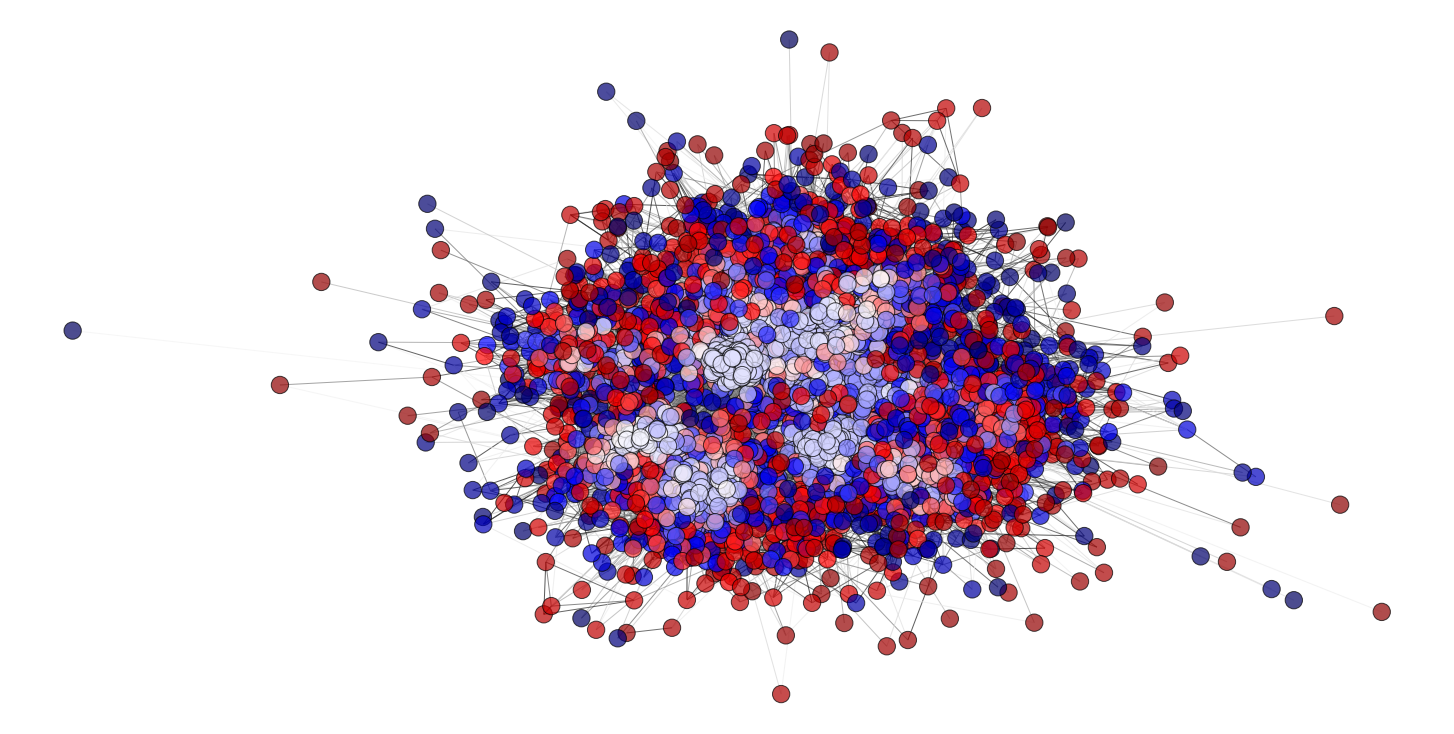

In [15]:
plt.figure(figsize=(20, 10))
nx.draw(sim_fb.graph, edgecolors='black',
        node_color=[sim_fb.graph.nodes[i]['opinion'] for i in sim_fb.graph.nodes],
        cmap='seismic', alpha=0.7, vmin=0, vmax=1,
        edge_color=[sim_fb.graph.edges[i, j]['weight'] for i, j in sim_fb.graph.edges],
        edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
plt.show()